In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [38]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [39]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-002_ses-t2_task-resteyesc_eeg.edf"
#processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
#processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info['ch_names'])
raw.set_montage('biosemi64')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=200, verbose=False)
raw_down_sampled.set_eeg_reference(ref_channels='average')
#I should maybe downsample, and maybe do it first for computational efficiency. The only thing is that then almost all the data will be in simpochs, so maybe I need stricter limits for gfp peakes.
#Bad segments can maybe be identified with Christoffers algorithm, anything else? I want to do this at the end of the pipeline I think.

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']


[PCA] Explained variance of selected components : 93.75%
Power of components removed by DSS: 0.87
(245760, 64)
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 64 x 48000 (240.0 s), ~23.5 MB, data loaded>

In [40]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, unorderd_adj_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

def gfp_normed_diss_data2(indices, data, gfp):
    indexed_data = data[:, indices]
    indexed_gfp = gfp[indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

In [41]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return diss

def diss2(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data2(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices)-1, data.shape[0]))
    for t in range(1, len(indices)):
        diss[t-1, :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t-1])
    return diss

In [42]:
def epoched_stability1(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stabilty = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stabilty[e] = np.mean(for_convex)
    return stability, convex_stabilty

def epoched_stability2(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stability = np.ndarray(shape=(epochs_array.shape[0]))
    switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    significant_switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    peaks = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        if e == 0:
            data_at_peaks = data[:, indices]
            full_data = data
        else:
            data_at_peaks = np.concatenate((data_at_peaks, data[:, indices]), axis=1)
            full_data = np.concatenate((full_data, data), axis=1)
        d = diss2(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        freq = 0
        sfreq = 0
        for s in individual_map_stability:
            if s > 0:
                freq += 1
            if s > 0.4:
                sfreq += 1
        switching_freq[e] = freq
        significant_switching_freq[e] = sfreq
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stability[e] = np.mean(for_convex)
        peaks[e] = len(indices)
    return stability, switching_freq, convex_stability, significant_switching_freq, peaks, full_data, data_at_peaks

Bad epoch idenfication - based on topographic stability

Between GFP peaks

In [43]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, overlap=0.5)

In [44]:
print(ones_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 200 original time points ...
0 bad epochs dropped
(479, 64, 200)


In [45]:
epoched_stability, epoched_switching_freq, convex_stabilty, significant_switching_freq, peaks, _, _ = epoched_stability2(ones_epochs)

Using data from preloaded Raw for 479 events and 200 original time points ...


Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

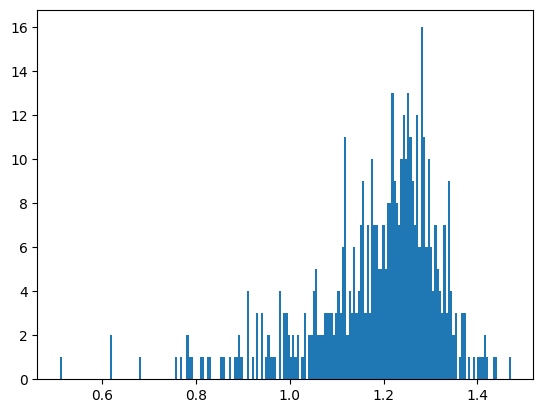

In [46]:
plt.hist(convex_stabilty, bins=200)
plt.show()

In [47]:
timepoints = np.where(convex_stabilty>=np.median(convex_stabilty))[0]
print((timepoints)/2)

[  1.5   2.    8.5  10.5  11.   11.5  15.5  16.   18.   20.5  21.   23.
  25.   27.   27.5  35.   35.5  36.   36.5  37.   37.5  38.   38.5  39.
  39.5  40.5  41.5  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.
  46.5  47.   48.5  49.   49.5  50.5  51.   51.5  52.   54.5  55.   55.5
  58.5  59.   59.5  60.   60.5  61.   61.5  62.5  63.   63.5  64.   64.5
  65.   65.5  66.   67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.
  71.5  72.   72.5  73.   73.5  74.   74.5  75.   75.5  77.   77.5  78.
  78.5  79.   80.   80.5  81.   82.5  83.   83.5  84.   84.5  85.   85.5
  86.   86.5  88.   88.5  89.   89.5  90.   90.5  91.   92.5  93.   93.5
  94.   95.   95.5  97.5  98.   98.5  99.   99.5 100.  100.5 101.  101.5
 102.  102.5 103.  103.5 104.  104.5 105.  105.5 107.  107.5 108.  108.5
 109.  109.5 110.  110.5 111.  111.5 112.  112.5 113.5 114.  115.  115.5
 117.5 118.  118.5 119.  119.5 120.  120.5 121.  121.5 122.  123.5 124.
 124.5 125.  125.5 126.  126.5 127.  127.5 128.  128.5 12

Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

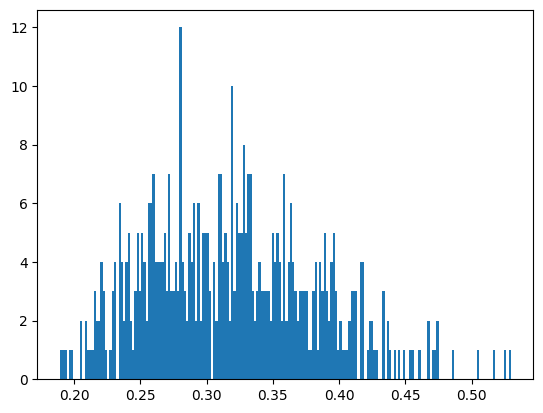

In [48]:
plt.hist(epoched_stability, bins=200)
plt.show()

In [49]:
timepoints = np.where(epoched_stability>=np.median(epoched_stability))[0]
print((timepoints)/2)

[  0.    1.5   2.    3.    3.5   4.    8.5  11.   11.5  23.   27.   27.5
  28.   28.5  29.   35.   35.5  36.   36.5  37.   37.5  38.   38.5  39.
  40.5  41.   41.5  42.   43.   43.5  44.   45.   45.5  46.   46.5  47.
  47.5  48.5  49.   49.5  50.5  51.   51.5  54.5  55.   55.5  56.   58.
  58.5  59.   59.5  60.   60.5  61.   61.5  62.   62.5  63.5  64.   64.5
  65.   65.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   74.5  75.   75.5  76.   77.   77.5  78.
  78.5  79.   80.   80.5  81.   82.5  83.   83.5  84.   84.5  85.   85.5
  86.   86.5  88.   88.5  89.   89.5  90.   90.5  91.   92.5  95.   95.5
  97.5  98.   98.5  99.   99.5 100.  100.5 101.  101.5 102.  102.5 103.
 103.5 104.  104.5 105.  105.5 106.  106.5 107.  107.5 108.  108.5 109.
 110.5 111.  111.5 112.  115.  115.5 118.  118.5 119.  120.5 121.  121.5
 122.  123.5 124.  124.5 125.  125.5 126.  126.5 127.  128.  128.5 129.
 130.5 131.  131.5 132.  134.  134.5 135.  135.5 138.  141

In [50]:
idx = np.where((epoched_stability>=np.median(epoched_stability)) & (convex_stabilty>=np.median(convex_stabilty)))[0]
print((idx-1)/2)

[  1.    1.5   8.   10.5  11.   22.5  26.5  27.   34.5  35.   35.5  36.
  36.5  37.   37.5  38.   38.5  40.   41.   41.5  42.5  43.   43.5  44.5
  45.   45.5  46.   46.5  48.   48.5  49.   50.   50.5  51.   54.   54.5
  55.   58.   58.5  59.   59.5  60.   60.5  61.   62.   63.   63.5  64.
  64.5  65.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.
  71.5  72.   72.5  73.   73.5  74.   74.5  75.   76.5  77.   77.5  78.
  78.5  79.5  80.   80.5  82.   82.5  83.   83.5  84.   84.5  85.   85.5
  86.   87.5  88.   88.5  89.   89.5  90.   90.5  92.   94.5  95.   97.
  97.5  98.   98.5  99.   99.5 100.  100.5 101.  101.5 102.  102.5 103.
 103.5 104.  104.5 105.  106.5 107.  107.5 108.  108.5 110.  110.5 111.
 111.5 114.5 115.  117.5 118.  118.5 120.  120.5 121.  121.5 123.  123.5
 124.  124.5 125.  125.5 126.  126.5 127.5 128.  128.5 130.  130.5 131.
 131.5 133.5 134.  134.5 135.  137.5 141.5 142.  144.  144.5 145.  145.5
 146.  148.5 149.  149.5 150.  150.5 151.  151.5 155.  159.

Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

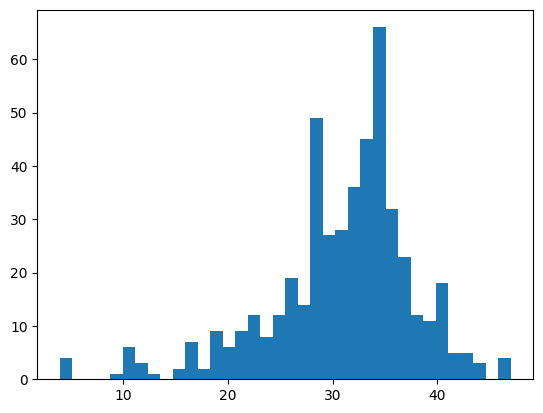

In [51]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

In [52]:
timepoints = np.where(epoched_switching_freq>300)[0]
print((timepoints)/2)

[]


The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

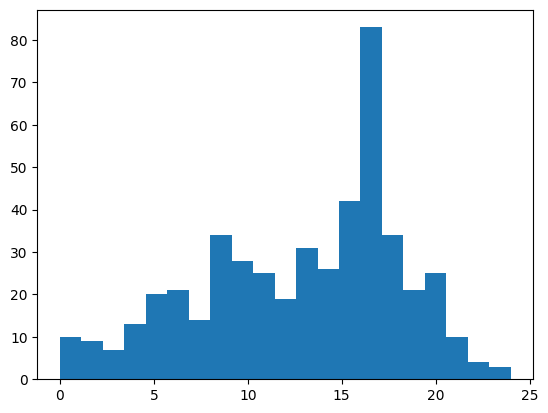

In [53]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

In [54]:
timepoints = np.where(significant_switching_freq==-1)[0]
print((timepoints)/2)

[]


Number of GFP peaks for each epoch

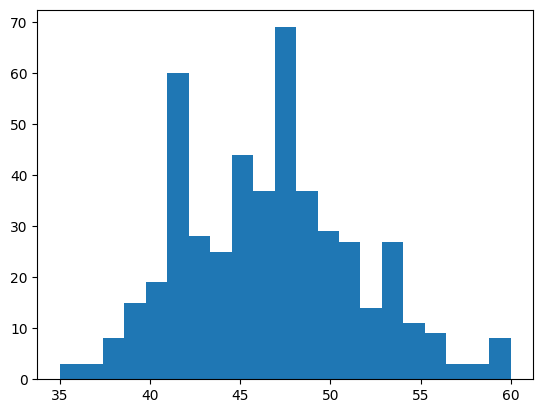

In [55]:
plt.hist(peaks, bins=21)
plt.show()

In [56]:
timepoints = np.where(peaks>500)[0]
print((timepoints)/2)

[]


Looking at scatter plot between swithcing frequencies and number of GFP peaks

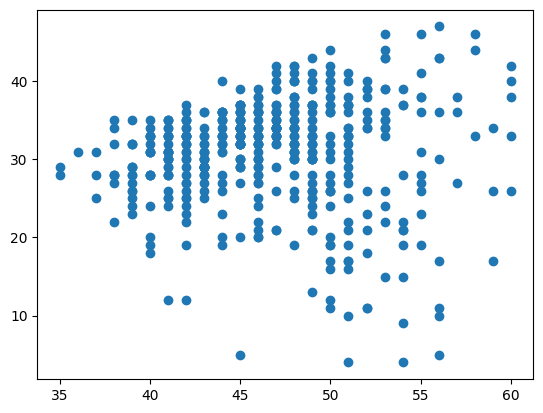

In [57]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

In [58]:
idx = np.where((epoched_switching_freq < 0))[0]
print((idx-1)/2)

[]


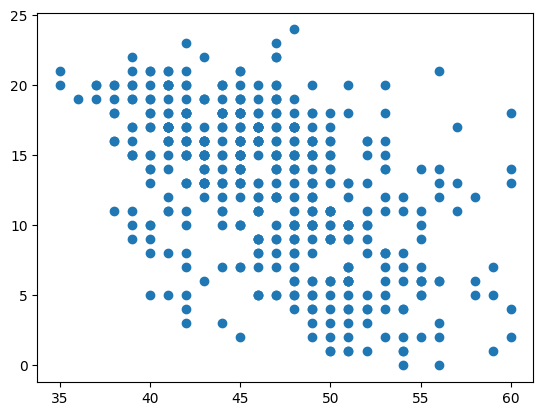

In [59]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

In [60]:
idx = np.where((peaks > 57))[0]
print(idx)
print((idx-1)/2)

idx = np.where((peaks < 28) & (significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((significant_switching_freq == 0))[0]
print((idx-1)/2)

[ 10  28  29  33  34  37 408 409 415 416 470]
[  4.5  13.5  14.   16.   16.5  18.  203.5 204.  207.  207.5 234.5]
[]
[  3.  156.5]


Looking at average absoluteDISS in relation to switching frequencies.

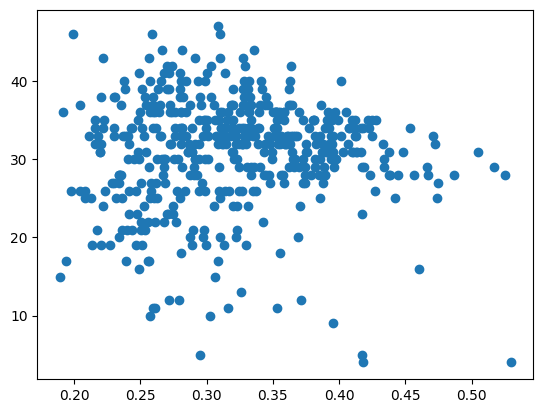

In [61]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

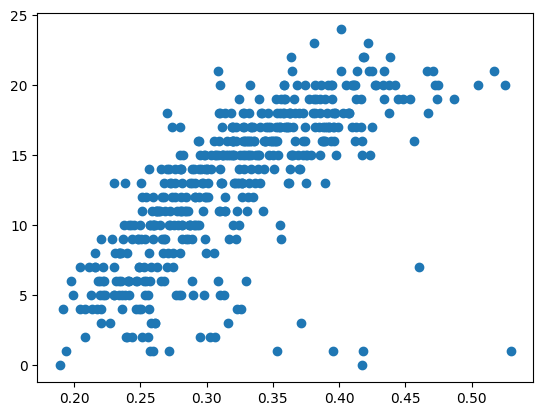

In [62]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

In [63]:
idx = np.where((epoched_stability > 10.5) & (significant_switching_freq < 5))[0]
print((idx-1)/2)

[]


Same but with average DISS

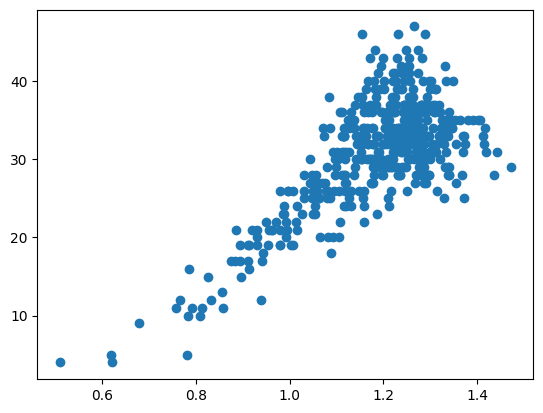

In [64]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

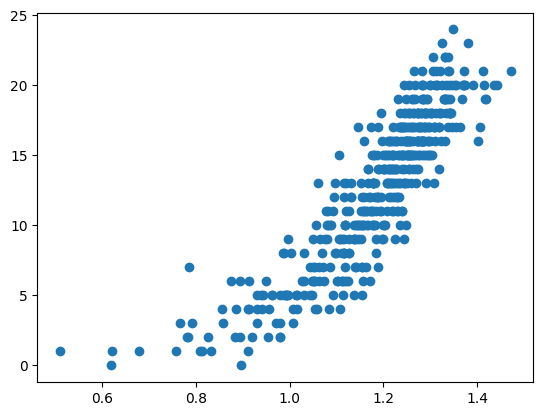

In [65]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

In [66]:
print(epoched_stability[110*2], convex_stabilty[110*2], epoched_switching_freq[110*2], significant_switching_freq[110*2])

0.30673695571109116 1.219166148679591 33.0 15.0


In [67]:
print(epoched_stability[int(109.5*2)], convex_stabilty[int(109.5*2)], epoched_switching_freq[int(109.5*2)], significant_switching_freq[int(109.5*2)])

0.31135184960307344 1.2194811586072978 33.0 15.0


In [68]:
print(epoched_stability[int(110.5*2)], convex_stabilty[int(110.5*2)], epoched_switching_freq[int(110.5*2)], significant_switching_freq[int(110.5*2)])

0.3818515814476243 1.3249095033855387 33.0 20.0


Scatter of the two stability types

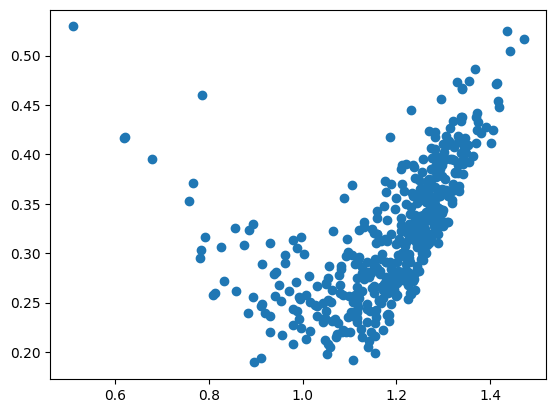

In [69]:
plt.scatter(convex_stabilty, epoched_stability)
plt.show()

In [70]:
idx = np.where((epoched_stability>0.3) & (convex_stabilty<0.9))[0]
print(idx)
print((idx)/2)

[  0   6   7   8   9  56  57  58 323 324 338 400 410 411]
[  0.    3.    3.5   4.    4.5  28.   28.5  29.  161.5 162.  169.  200.
 205.  205.5]


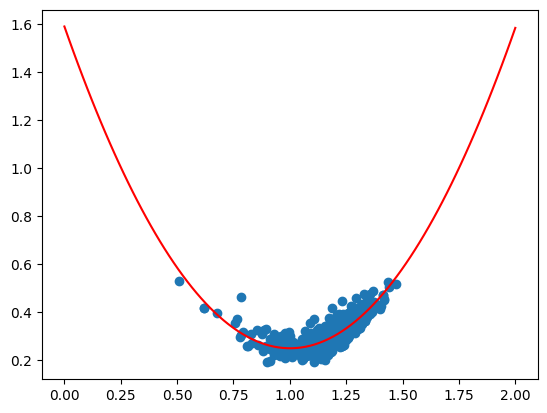

In [71]:
fit = np.poly1d(np.polyfit(convex_stabilty, epoched_stability, 2))
polyline = np.linspace(0, 2, 100)
plt.scatter(convex_stabilty, epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()


In [72]:
print(fit)

       2
1.339 x - 2.68 x + 1.59


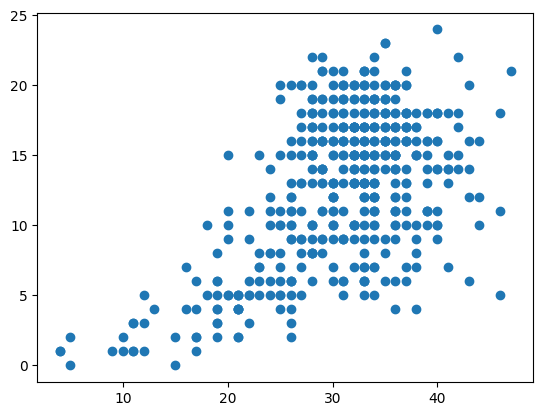

In [73]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

In [74]:
idx = np.where((epoched_switching_freq > 250) & (significant_switching_freq < 15))[0]
print((idx-1)/2)

[]


In [75]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

At GFP peaks

In [76]:
at_epoched_stability, at_convex_stabilty = epoched_stability1(ones_epochs)

Using data from preloaded Raw for 479 events and 200 original time points ...


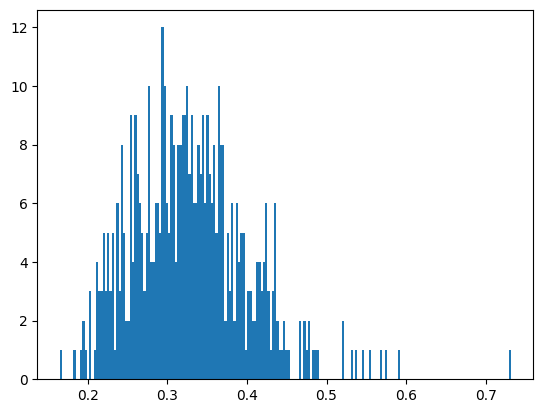

In [77]:
plt.hist(at_epoched_stability, bins=200)
plt.show()

In [78]:
idx = np.where(at_epoched_stability > np.median(at_epoched_stability))[0]
print((idx)/2)


[  0.    3.    3.5   4.    4.5   7.    9.    9.5  12.   12.5  14.5  17.
  19.5  21.5  22.   26.5  27.   27.5  28.   28.5  29.   29.5  30.   33.5
  34.   34.5  35.   35.5  37.   37.5  38.   38.5  41.   41.5  42.   43.5
  44.   44.5  45.   45.5  46.   46.5  47.   47.5  49.   50.5  51.   51.5
  53.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   63.5  64.   64.5  65.   69.   69.5  70.
  70.5  71.   71.5  72.   72.5  73.   73.5  74.   74.5  75.   75.5  77.5
  78.   78.5  79.   79.5  80.   83.5  84.   84.5  85.   88.   88.5  90.
  90.5  97.5 101.  101.5 102.  102.5 103.  106.5 108.  114.5 115.  116.
 119.  119.5 121.  121.5 122.  124.5 125.  125.5 126.5 127.  128.5 129.
 131.  131.5 135.  135.5 136.  136.5 137.  137.5 138.  139.  139.5 140.
 140.5 141.  141.5 142.  143.5 144.  144.5 145.  145.5 146.  147.5 148.
 148.5 149.  150.5 151.  151.5 152.  157.  157.5 158.  158.5 159.  160.
 160.5 161.  161.5 162.  162.5 164.5 165.  165.5 166.  166.

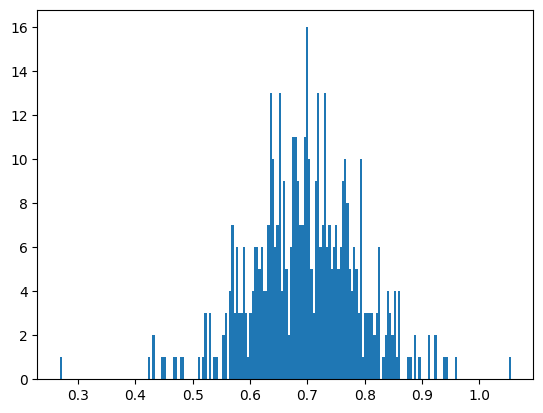

In [79]:
plt.hist(at_convex_stabilty, bins=200)
plt.show()

In [80]:
idx = np.where(at_convex_stabilty > 10.8)[0]
print((idx-1)/2)
idx = np.where(at_convex_stabilty < 0.015)[0]
print((idx-1)/2)

[]
[]


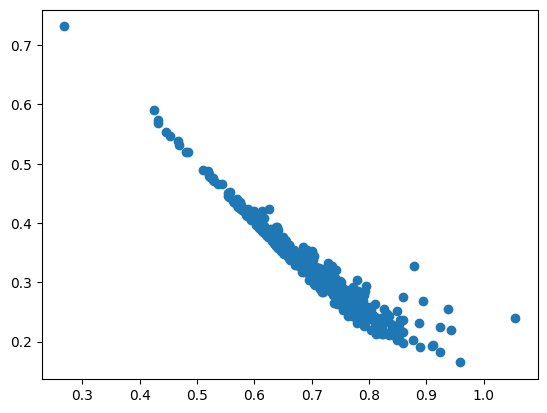

In [83]:
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.show()

In [86]:
idx = np.where((at_convex_stabilty > 0.88) & (at_epoched_stability > 0.2))[0]
print((idx))

[ 3  4 10 11 12 16]


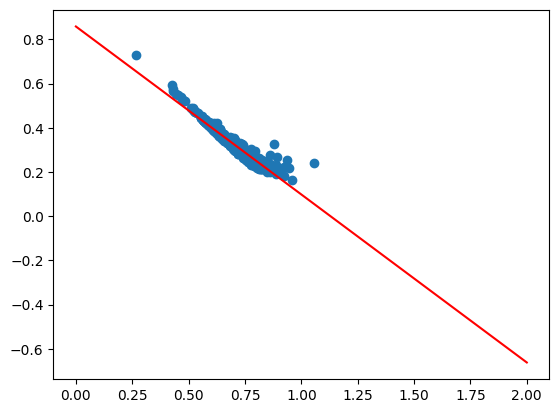

In [82]:
fit = np.poly1d(np.polyfit(at_convex_stabilty, at_epoched_stability, 1))
polyline = np.linspace(0, 2, 100)
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()

In [87]:
print(fit)

 
-0.7601 x + 0.8584


The median prinsipal for channel stability and pca heuristic analysis

In [88]:
idx = np.where((epoched_stability>=np.median(epoched_stability)) & (convex_stabilty>=np.median(convex_stabilty)) & (at_epoched_stability > np.median(at_epoched_stability)))[0]
print(idx)

[ 54  55  70  71  74  75  76  77  83  84  87  88  90  91  92  93  94  98
 101 102 103 109 110 111 117 118 119 120 121 122 123 127 128 129 130 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 155 156 157 158 160
 167 168 169 170 176 177 180 181 195 202 203 204 205 206 216 230 238 242
 243 244 249 250 251 253 254 257 258 262 263 270 271 276 284 289 290 291
 292 298 301 302 303 304 320 333 356 372 424 430 448 449 451 457]


In [89]:
channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)

In [90]:
anti_idx = np.arange(480)
anti_idx = np.delete(anti_idx, idx)
print(anti_idx)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  72  73  78  79
  80  81  82  85  86  89  95  96  97  99 100 104 105 106 107 108 112 113
 114 115 116 124 125 126 131 132 133 134 135 136 137 152 153 154 159 161
 162 163 164 165 166 171 172 173 174 175 178 179 182 183 184 185 186 187
 188 189 190 191 192 193 194 196 197 198 199 200 201 207 208 209 210 211
 212 213 214 215 217 218 219 220 221 222 223 224 225 226 227 228 229 231
 232 233 234 235 236 237 239 240 241 245 246 247 248 252 255 256 259 260
 261 264 265 266 267 268 269 272 273 274 275 277 278 279 280 281 282 283
 285 286 287 288 293 294 295 296 297 299 300 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 321 322 323 324 325 326 327 328 329 330
 331 332 334 335 336 337 338 339 340 341 342 343 34

In [92]:
#channelstab_epochs.drop(anti_idx)
channelstab_epochs.drop([0, 6, 7, 8, 9, 56, 57, 58, 323, 324, 338, 400, 410, 411, 3, 4, 10, 11, 12, 16])

Dropped 20 epochs: 0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 16, 56, 57, 58, 323, 324, 338, 400, 410, 411


Number of events,460
Events,1: 460
Time range,0.000 – 0.495 s
Baseline,off


Stability channel analysis

In [93]:
def remove_bad(mne_epoch_object, channel_name):
    raw = mne_epoch_object.copy()
    raw.drop_channels(channel_name)
    return raw

In [94]:
def leav_one_out(epochs_object):
    epoched_stability, _, _, _, _, _, _ = epoched_stability2(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _, _, _, _, _, _ = epoched_stability2(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [95]:
def leav_one_out2(epochs_object):
    epoched_stability, _ = epoched_stability1(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _ = epoched_stability1(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [96]:
#channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)
at_test1 = leav_one_out2(channelstab_epochs)
#channelstab_epochs.drop([100, 101, 102, 108, 109, 110, 111])
test1 = leav_one_out(channelstab_epochs)

At GFP peaks stability

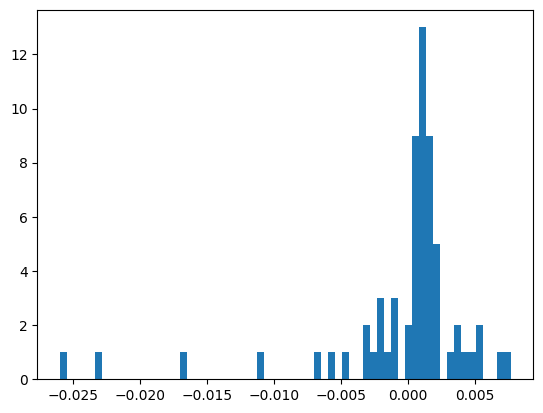

In [97]:
plt.hist(at_test1, bins=64)
plt.show()

In [98]:
order = np.argsort(at_test1)
print(channel_names[order])

['AF7' 'T8' 'FT7' 'F7' 'F4' 'TP7' 'P2' 'C6' 'TP8' 'T7' 'C5' 'FC5' 'F5'
 'P5' 'F8' 'FT8' 'FC6' 'AF8' 'F6' 'Fp1' 'FC1' 'CP4' 'FC4' 'F3' 'Cz' 'P7'
 'P8' 'AF3' 'CP5' 'C3' 'CP6' 'FC3' 'C2' 'P9' 'AF4' 'FC2' 'FCz' 'F2' 'Iz'
 'P10' 'Fz' 'AFz' 'F1' 'Fpz' 'C1' 'C4' 'P6' 'CP2' 'CP3' 'P4' 'PO8' 'CPz'
 'Oz' 'CP1' 'O2' 'PO7' 'O1' 'P3' 'Fp2' 'PO4' 'P1' 'POz' 'PO3' 'Pz']


Between GFP peaks stability

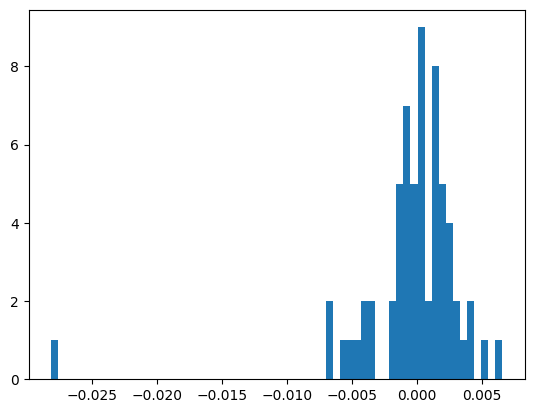

In [99]:
plt.hist(test1, bins=64)
plt.show()

In [100]:
order = np.argsort(test1)
print(channel_names[order])

['T7' 'FT7' 'POz' 'AF7' 'T8' 'Fp2' 'Pz' 'F4' 'F7' 'TP7' 'P9' 'F6' 'C3'
 'P2' 'FC5' 'C6' 'CPz' 'C4' 'P10' 'Fp1' 'TP8' 'F8' 'AF8' 'C5' 'F5' 'FC3'
 'CP4' 'Iz' 'FC1' 'Cz' 'Fpz' 'FC6' 'P5' 'P8' 'C1' 'FT8' 'P7' 'CP5' 'C2'
 'F1' 'FC4' 'CP3' 'CP6' 'CP2' 'AF3' 'FC2' 'P6' 'CP1' 'F3' 'FCz' 'F2' 'AF4'
 'Fz' 'AFz' 'O2' 'Oz' 'P4' 'PO8' 'P3' 'PO4' 'PO7' 'O1' 'P1' 'PO3']


In [101]:
print(kurtosis(test1))
print(skew(test1))

23.398546821242135
-4.064694958491875


PCA heuristic idea

In [102]:
print(ones_epochs.get_data().shape)
print(channelstab_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 200 original time points ...
(479, 64, 200)
(460, 64, 100)


In [103]:
_, _, _, _, _, data_all, data_at_peaks = epoched_stability2(channelstab_epochs)

In [104]:
data = data_at_peaks.T

In [105]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [106]:
def pca_auc(data):
    pca = sklearn.decomposition.PCA(random_state=9)
    pca.fit_transform(data)
    roc_curve = np.ndarray(shape=pca.components_.shape[0])
    explained_var = pca.explained_variance_ratio_
    percent = 0
    for v in range(roc_curve.shape[0]):
        percent += explained_var[v]
        roc_curve[v] = percent
    auc = np.trapz(roc_curve.flatten())
    return auc/pca.components_.shape[0], roc_curve

0.8906611634370836


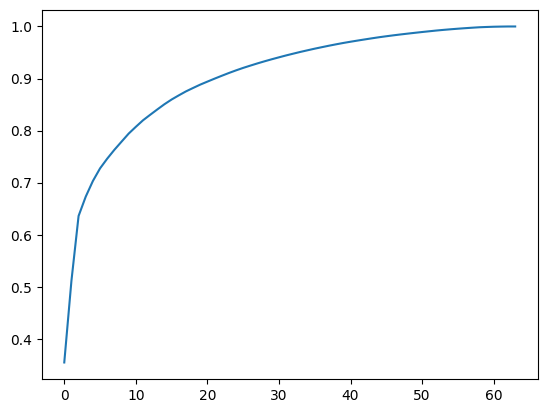

In [107]:
benchmark, rc = pca_auc(data)
print(benchmark)
plt.plot(rc)
plt.show()

In [108]:
pc_all_chanels = np.ndarray(64)
for c in range(len(channel_names)):
    dataaa = np.delete(data, c, axis=1)
    b, r = pca_auc(dataaa)
    pc_all_chanels[c] = b-benchmark

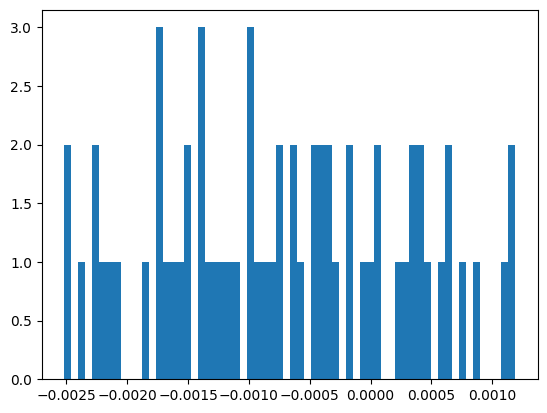

In [109]:
plt.hist(pc_all_chanels, bins=64)
plt.show()

In [110]:
order = np.argsort(pc_all_chanels)
print(channel_names[order])

['PO3' 'AFz' 'O2' 'O1' 'P1' 'PO8' 'Oz' 'F3' 'CP1' 'Fz' 'PO7' 'PO4' 'FC2'
 'FC4' 'AF3' 'P4' 'P6' 'FCz' 'AF8' 'P3' 'F2' 'Fp1' 'FC5' 'FC6' 'AF4' 'FC1'
 'Iz' 'CP2' 'Fpz' 'CP3' 'P7' 'F8' 'F5' 'C2' 'CP6' 'C1' 'FC3' 'F1' 'Cz'
 'CP4' 'CP5' 'P5' 'C3' 'FT8' 'C5' 'P2' 'T7' 'CPz' 'P8' 'Fp2' 'F6' 'P9'
 'P10' 'TP8' 'C4' 'F4' 'Pz' 'C6' 'AF7' 'FT7' 'F7' 'TP7' 'T8' 'POz']


In [111]:
bad_by_corr = np.where(pc_all_chanels > 0)[0]
print(channel_names[bad_by_corr])

['AF7' 'F7' 'FT7' 'T7' 'TP7' 'P9' 'POz' 'Pz' 'CPz' 'Fp2' 'F4' 'F6' 'C4'
 'C6' 'T8' 'TP8' 'P8' 'P10']


In [112]:
idx = np.where((at_test1 < 0) & (test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)

[ 1  6  7 14 15 39 50 51 52]


In [113]:
print(channel_names[idx])

['AF7' 'F7' 'FT7' 'T7' 'TP7' 'F4' 'C6' 'T8' 'TP8']


In [114]:
idx = np.where((at_test1 < 0) & (pc_all_chanels > 0))[0]
idx2 = np.where((test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)
print(idx2)

[ 1  6  7 14 15 39 50 51 52]
[ 1  6  7 14 15 23 29 30 31 33 39 40 49 50 51 52 60]


In [115]:
print(channel_names[idx])
print(channel_names[idx2])

['AF7' 'F7' 'FT7' 'T7' 'TP7' 'F4' 'C6' 'T8' 'TP8']
['AF7' 'F7' 'FT7' 'T7' 'TP7' 'P9' 'POz' 'Pz' 'CPz' 'Fp2' 'F4' 'F6' 'C4'
 'C6' 'T8' 'TP8' 'P10']


In [116]:
acum = []
for cn in channel_names[np.argsort(test1)]:
    if cn in channel_names[bad_by_corr]:
        print(cn)
        acum.append(cn)
    else:
        break
for cn in channel_names[np.argsort(at_test1)]:
    if cn in channel_names[bad_by_corr]:
        if cn not in acum:
            print(cn)
    else:
        break

T7
FT7
POz
AF7
T8
Fp2
Pz
F4
F7
TP7
P9
F6
